In [13]:
# PINN for Burgers' equation
# coded by St.Watermelon

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        self.h1 = Dense(20, activation='tanh')
        self.h2 = Dense(20, activation='tanh')
        self.h3 = Dense(20, activation='tanh')
        self.h4 = Dense(20, activation='tanh')
        self.h5 = Dense(20, activation='tanh')
        self.h6 = Dense(20, activation='tanh')
        self.u = Dense(1, activation='linear')


    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out


class Pinn(object):

    def __init__(self):

        self.lr = 0.001
        self.opt = Adam(self.lr)

        self.burgers = Burgers()
        self.burgers.build(input_shape=(None, 2))

    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            tape.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = self.burgers(xt_t)
            u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)
        del tape

        return u_t + u*u_x - (0.01/np.pi)*u_xx


    def save_weights(self, path):
        self.burgers.save_weights(path + 'burgers.h5')


    def load_weights(self, path):
        self.burgers.load_weights(path + 'burgers.h5')


    def learn(self, xt_col, xt_bnd, tu_bnd):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f))

            tu_bnd_hat = self.burgers(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd_hat-tu_bnd))

            loss = loss_col + loss_bnd

        grads = tape.gradient(loss, self.burgers.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))

        return loss


    def predict(self, xt):
        tu = self.burgers(xt)
        return tu


    def train(self, max_num):

        # initial and boundary condition
        x_data = np.linspace(-1.0, 1.0, 500)
        t_data = np.linspace(0.0, 1.0, 500)
        xt_bnd_data = []
        tu_bnd_data = []

        for x in x_data:
            xt_bnd_data.append([x, 0])
            tu_bnd_data.append([-np.sin(np.pi * x)])

        for t in t_data:
            xt_bnd_data.append([1, t])
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t])
            tu_bnd_data.append([0])

        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # collocation point
        t_col_data = np.random.uniform(0, 1, [20000, 1])
        x_col_data = np.random.uniform(-1, 1, [20000, 1])
        xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
        xt_col_data = np.concatenate((xt_col_data, xt_bnd_data), axis=0)

        train_loss_history = []

        for iter in range(int(max_num)):

            loss = self.learn(tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                       tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                       tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32))

            train_loss_history.append([iter, loss.numpy()])

            print('iter=', iter, ', loss=', loss.numpy())

        self.save_weights("./save_weights/")

        np.savetxt('./save_weights/loss.txt', train_loss_history)
        train_loss_history = np.array(train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()

iter= 0 , loss= 0.20656717
iter= 1 , loss= 0.17763312
iter= 2 , loss= 0.16181955
iter= 3 , loss= 0.15235655
iter= 4 , loss= 0.1467879
iter= 5 , loss= 0.14514287
iter= 6 , loss= 0.1472181
iter= 7 , loss= 0.15112005
iter= 8 , loss= 0.15399693
iter= 9 , loss= 0.15430214
iter= 10 , loss= 0.15235876
iter= 11 , loss= 0.14934407
iter= 12 , loss= 0.14640178
iter= 13 , loss= 0.14423078
iter= 14 , loss= 0.14300916
iter= 15 , loss= 0.14254646
iter= 16 , loss= 0.14253831
iter= 17 , loss= 0.14275293
iter= 18 , loss= 0.14305848
iter= 19 , loss= 0.14334776
iter= 20 , loss= 0.143479
iter= 21 , loss= 0.14330305
iter= 22 , loss= 0.14274803
iter= 23 , loss= 0.14187779
iter= 24 , loss= 0.14087074
iter= 25 , loss= 0.13993658
iter= 26 , loss= 0.13922559
iter= 27 , loss= 0.13877973
iter= 28 , loss= 0.13854384
iter= 29 , loss= 0.13841587
iter= 30 , loss= 0.13829508
iter= 31 , loss= 0.13810141
iter= 32 , loss= 0.1377746
iter= 33 , loss= 0.13727908
iter= 34 , loss= 0.13662319
iter= 35 , loss= 0.13587205
iter= 3

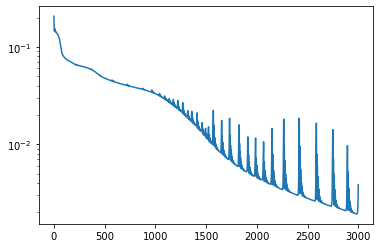

In [14]:
max_num = 3000
agent = Pinn()
agent.train(max_num)


In [31]:
agent2 = Pinn()
agent2.load_weights('./save_weights/')

t1_test_data = 0.25*np.ones(1000).reshape(1000, 1)
t2_test_data = 0.5*np.ones(1000).reshape(1000, 1)
t3_test_data = 0.75*np.ones(1000).reshape(1000, 1)

x_test_data = np.linspace(-1, 1, 1000).reshape(1000, 1)

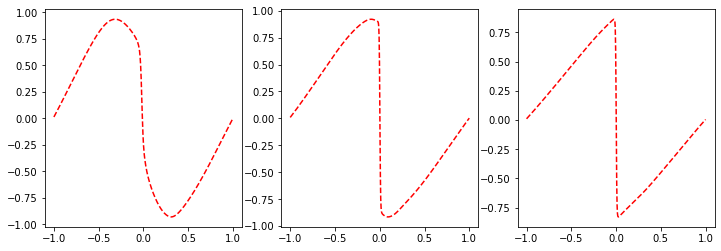

In [32]:
plt.subplots(figsize=(12, 4))

xt_test = np.concatenate([x_test_data, t1_test_data], axis=1)
u_result = agent2.predict(xt_test)

plt.subplot(1,3,1)
plt.plot(x_test_data, u_result, 'r--')

xt_test = np.concatenate([x_test_data, t2_test_data], axis=1)
u_result = agent2.predict(xt_test)

plt.subplot(1,3,2)
plt.plot(x_test_data, u_result, 'r--')

xt_test = np.concatenate([x_test_data, t3_test_data], axis=1)
u_result = agent2.predict(xt_test)

plt.subplot(1,3,3)
plt.plot(x_test_data, u_result, 'r--')